# Rendering and Visualization of Meshes

Since version `0.16.0`, Kaolin provides an easy rendering function for meshes.

This render function can also be used to interactively view a mesh directly in a notebook, using mouse events to change view.

In [1]:
pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy
import logging
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import torch

import kaolin as kal
import nvdiffrast
from kaolin.rep import SurfaceMesh

from tutorial_common import COMMON_DATA_DIR

def sample_mesh_path(fname):
    return os.path.join(COMMON_DATA_DIR, 'meshes', fname)

def print_tensor(t, name='', **kwargs):
    print(kal.utils.testing.tensor_info(t, name=name, **kwargs))
    

## Easy Import

Simply import a mesh from `usd`, `gltf` or `obj` format; to enable rendering ensure to set `triangulate=True`.

(Note that material standards vary widely and for USD we only support `USDPreviewSurface` spec at this time, as well as partial PBR support for `gltf` and `obj`).

In [3]:
# Import and triangulate to enable rasterization; move to GPU
mesh = kal.io.import_mesh(sample_mesh_path('armchair.usdc'), triangulate=True).cuda()
    
# Normalize so it is easy to set up default camera
mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

# Inspect
print(mesh)

SurfaceMesh object with batching strategy NONE
            vertices: [9204, 3] (torch.float32)[cuda:0]  
               faces: [18400, 3] (torch.int64)[cuda:0]  
        face_normals: [18400, 3, 3] (torch.float32)[cuda:0]  
                 uvs: [36800, 2] (torch.float32)[cuda:0]  
        face_uvs_idx: [18400, 3] (torch.int64)[cuda:0]  
material_assignments: [18400] (torch.int16)[cuda:0]  
           materials: list of length 2
       face_vertices: if possible, computed on access from: (faces, vertices)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, computed on access 

## Easy Lighting Parameters

Let's create default camera and Spherical Gaussian lighting.

In [4]:
# Default rendering settings
camera = kal.render.easy_render.default_camera(512).cuda()
lighting = kal.render.easy_render.default_lighting().cuda()


## Easy Render Function

Now let's render different passes for this mesh, using its loaded materials. We can also set another material type.

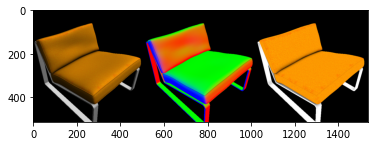

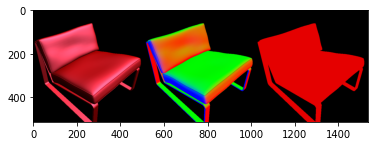

In [5]:
def render(in_cam, **kwargs):
    render_res = kal.render.easy_render.render_mesh(in_cam, mesh, lighting=lighting, **kwargs)
    # render pass
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    # normals pass
    normals = render_res[kal.render.easy_render.RenderPass.normals].squeeze(0).clamp(0, 1)
    # albedo pass
    albedo = render_res[kal.render.easy_render.RenderPass.albedo].squeeze(0).clamp(0, 1)
    return (torch.cat([img, normals, albedo], dim=1) * 255.).to(torch.uint8)

# Show simple render
plt.figure()
plt.imshow(render(camera).cpu().numpy())
    
# Let's set custom materials and assignments
materials = [kal.render.easy_render.default_material((0.9, 0.0, 0.0)).cuda()]
material_assignments = torch.zeros_like(mesh.material_assignments)
plt.figure()
plt.imshow(render(camera, custom_materials=materials, custom_material_assignments=material_assignments).cpu().numpy())

## Easy Interactive Visualizer

The render function above can be used to instantiate an interactive renderer. While there exist many production 3D viewers, this jupyter viewer allows easy inspection and debugging of custom render functions that are used e.g. inside 3D DL training loop.

Run this cell, and click and drag inside the rendered viewport (note: first interaction can be slow).

In [7]:
def fast_render(in_cam, factor=8):
    lowres_cam = copy.deepcopy(in_cam)
    lowres_cam.width = in_cam.width // factor
    lowres_cam.height = in_cam.height // factor
    return render(lowres_cam)

visualizer = kal.visualize.IpyTurntableVisualizer(
    512, 512 * 3, copy.deepcopy(camera), render, fast_render=fast_render,
    max_fps=24, world_up_axis=1)
visualizer.show()

Canvas(height=512, width=1536)

Output()